# Pytorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
- [Ground truth notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb)
- [Book version](https://www.learnpytorch.io/01_pytorch_workflow)

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. Data (Preparing And Loading)

Data can be almost anything ... in machine learning:
- Spreadsheet
- Images
- Videos
- Audios
- DNA
- Text
- ...etc

ML is a game of 2 parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some _known_ data using the linear regression formula.

We'll use a linear regression formula to make a straight line with _known_ **parameters**.

### Generate Data

In [2]:
# Create *known* parameters (Our model has to use these parameters in order to fit the data we're going to generate)
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).reshape(-1, 1) # input
y = weight * X + bias # output

print(X[:10])
print(y[:10])
print(len(X), len(y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])
50 50


### Splitting Data Into Training and Testing Set

In [3]:
X_train, X_test = X.split(int(0.8 * len(X)))
len(X_train), len(X_test)

(40, 10)

In [4]:
y_train, y_test = X.split(int(0.8 * len(y)))
len(y_train), len(y_test)

(40, 10)

### Visualize Data

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # Plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
    
    if predictions is not None:
        # Plot the predictions in red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size": "14"})

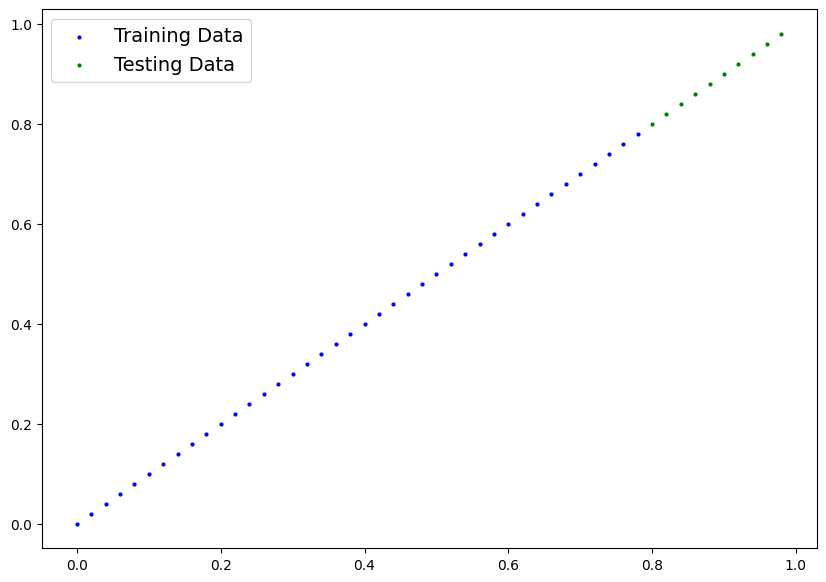

In [6]:
plot_predictions()

## 2. Build Model

Our objective is to build a model that can predict the green dots above using the blue dots.

In [7]:
# Create a Linear Regression Model class
class LinearRegressionModel(nn.Module): # <- base class for all NN models
    def __init__(self):
        super().__init__()
        
        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), # starts with random weight that will get adjusted as the model learns
                                    requires_grad=True) # can we update this value with gradient descent?
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- x is the input data
        return self.weights * x + self.bias # the linear regression formula

What our model does?
- Start with random values (weight & bias)
- Look at training data and adjust random values to better represent the ideal values (the weight and bias we used to create the data)

### Checking The Content Of Our Model

In [8]:
# Create a random seed - so that the parameters in our model stay the same everytime
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters()) # refers to the weight and bias we set

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# Check out the named parameters
list(model_0.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.3367], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.1288], requires_grad=True))]

In [10]:
# Alternative syntax
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# Our objective is to make these parameters as close as possible to the weight and bias we set
weight, bias

(0.7, 0.3)

### Try Making Prediction With Our Currently Untrained Model

Note: When we pass data through our model, it's going to run it through the model's `forward()` method.

In [12]:
with torch.inference_mode(): # turn off gradient tracking
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
y_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

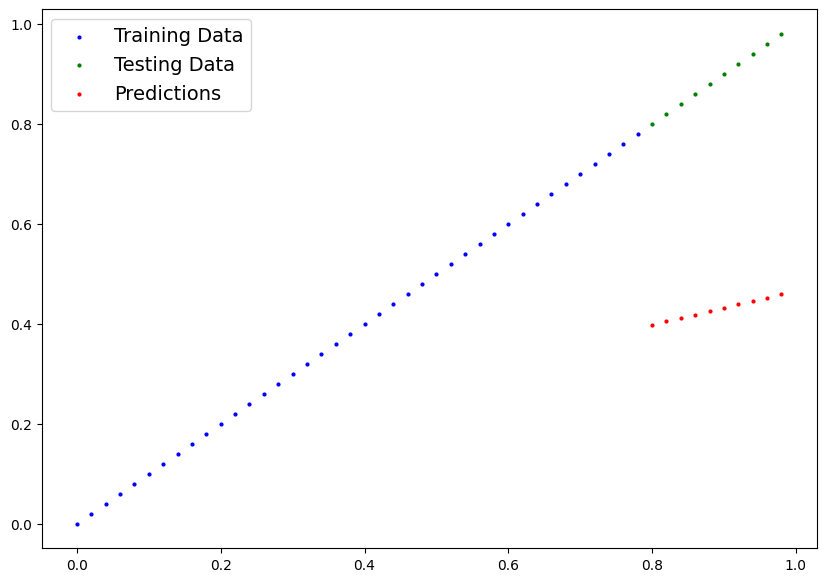

In [14]:
plot_predictions(predictions=y_preds)

As you can see, our prediction is way off compared to the correct values.

## 3. Train Model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters, the weights and bias values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

### Creating a loss function and optimizer in PyTorch

**Loss function / cost function / criterion**: measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). The lower the better.

**Optimizer**: tells your model how to update its internal parameters to best lower the loss.

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss() # this is a class, hence the initiation
loss_fn # L1Loss = MAE

L1Loss()

In [16]:
# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Creating An Optimization Loop

We're going to create a training loop (and testing loop).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

#### Training Loop

1. Forward pass: The model goes through all of the training data once, performing its forward() function calculations. `model(x_train)`
2. Calculate the loss: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. `loss = loss_fn(y_pred, y_train)`
3. Zero gradients: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. `optimizer.zero_grad()`
4. Perform backpropagation on the loss: Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards". `loss.backward()`
5. Update the optimizer (gradient descent): Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.

#### Testing Loop

1. Forward pass: The model goes through all of the training data once, performing its forward() function calculations. `model(x_test)`
2. Calculate the loss: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. `loss = loss_fn(y_pred, y_test)`
3. Calulate evaluation metrics (optional): Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.

In [17]:
# Epoch: 1 complete loop through the data
epochs = 400

# Lists to track values (for plotting, etc.)
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    model_0.train() # put model in training mode (default mode). Some layers care about this (e.g BatchNorm, Dropout)
    
    # 1. Forward pass
    y_preds = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)
    
    # 3. Optimizer zero grad - reset the gradients of all parameters
    optimizer.zero_grad() # ensures that the gradient are reset to zero before computing new gradients for current iteration
    
    # 4. Perform backpropagation on the loss with respect to the model's parameters
    loss.backward()
    
    # 5. Progress/step the optimizer (gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval() # turn off some settings that're not needed during evaluation/testing
    with torch.inference_mode():
        # 1. Forward pass
        test_preds = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_preds, y_test)
    
    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy()) # .detach returns a new tensor detached from curr graph
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())
        

Epoch: 0 | Loss: 0.16443711519241333 | Test loss: 0.45346564054489136
OrderedDict([('weights', tensor([0.3401])), ('bias', tensor([0.1338]))])
Epoch: 10 | Loss: 0.1380200982093811 | Test loss: 0.38710135221481323
OrderedDict([('weights', tensor([0.3720])), ('bias', tensor([0.1718]))])
Epoch: 20 | Loss: 0.1240791454911232 | Test loss: 0.3392970860004425
OrderedDict([('weights', tensor([0.3999])), ('bias', tensor([0.1948]))])
Epoch: 30 | Loss: 0.11643104255199432 | Test loss: 0.3055989146232605
OrderedDict([('weights', tensor([0.4243])), ('bias', tensor([0.2068]))])
Epoch: 40 | Loss: 0.11116994917392731 | Test loss: 0.28111687302589417
OrderedDict([('weights', tensor([0.4462])), ('bias', tensor([0.2118]))])
Epoch: 50 | Loss: 0.10716994106769562 | Test loss: 0.2633168399333954
OrderedDict([('weights', tensor([0.4662])), ('bias', tensor([0.2118]))])
Epoch: 60 | Loss: 0.10350941121578217 | Test loss: 0.2502627968788147
OrderedDict([('weights', tensor([0.4848])), ('bias', tensor([0.2083]))])

Read this [stack overflow](https://stackoverflow.com/a/76645793) answer to better understand step 3 in training loop!

Read this [stack overflow](https://stackoverflow.com/a/53975741) answer to better understand step 4 in training loop!

Note:
`loss.backward()` relies on the computation graph that was constructed during the forward pass. That's why we don't need to pass it anything!

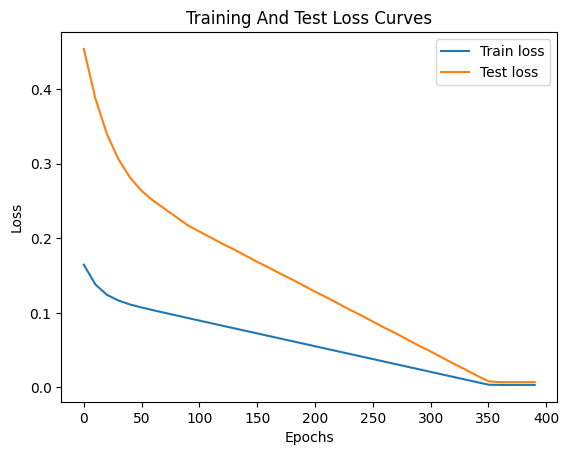

In [18]:
# We can use the data we tracked to plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training And Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## 4. Making predictions with a trained PyTorch model (inference)

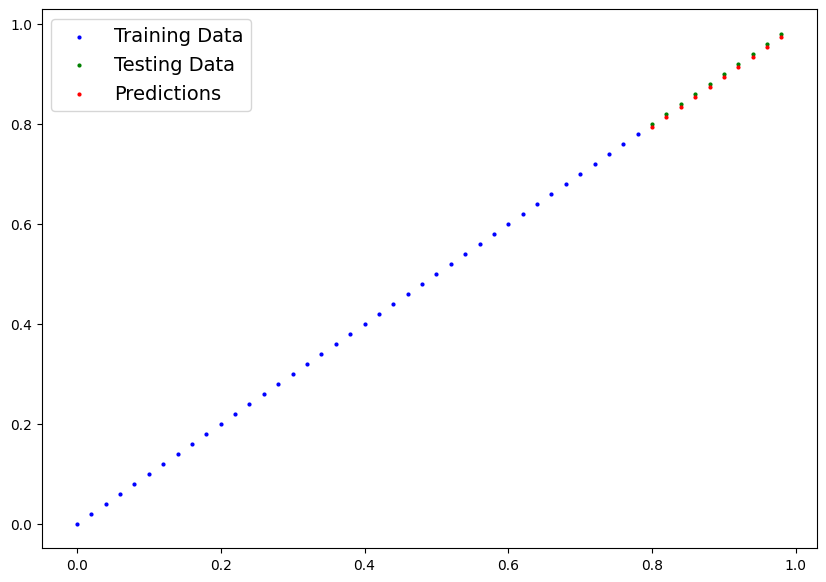

In [19]:
# Always use eval() and inference_mode() to greatly speedup inference
model_0.eval()
with torch.inference_mode():
    new_y_preds = model_0(X_test)
    
plot_predictions(predictions=new_y_preds)

## 5. Saving and loading a PyTorch model

Saving and loading in PyTorch is done under the hood using Python's [pickle](https://docs.python.org/3/library/pickle.html) utility.

> Note: It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.

### Saving A PyTorch Model

[The recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

In [20]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Aug  4 13:16 models/01_pytorch_workflow_model_0.pth


### Loading A PyTorch Model

Notice that the `load_state_dict()` function takes a dictionary object, NOT a path to a saved object. This means that you must deserialize the saved `state_dict` before you pass it to the `load_state_dict()` function. For example, you CANNOT load using `model.load_state_dict(PATH)`.

In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

### Test Loaded Model

In [23]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [24]:
len(y_preds)

40

In [25]:
# Compare previous model predictions with loaded model predictions (these should be the same)
new_y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting It All Together

Speaking of practice, let's put everything we've done so far together.

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

In [63]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [65]:
# Our target weight, bias
weight, bias = 0.7, 0.3

# Create data based on the weight and bias above
X = torch.arange(0, 1, 0.02).reshape(-1, 1)
y = weight * X + bias

In [66]:
# Split data
X_train, X_test = X.split(int(0.8 * len(X)))
y_train, y_test = X.split(int(0.8 * len(y)))

In [92]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(8, 5))
    plt.scatter(train_data, train_labels, c="r", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="b", s=4, label="Predictions")
    plt.legend()

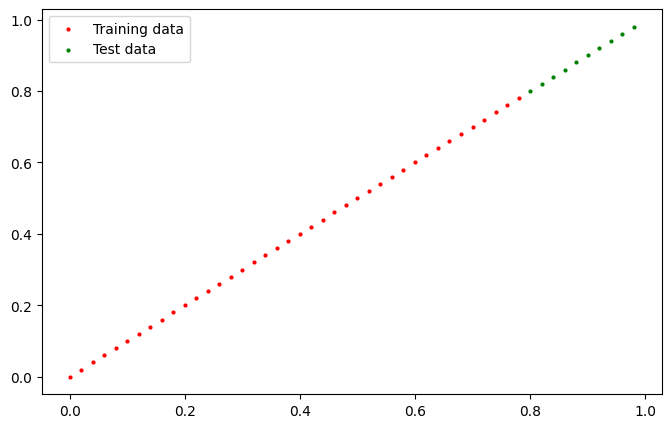

In [68]:
plot_predictions()

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are 1 since our data has 1 input feature (X) per label (y).

In [69]:
# Build model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x) # equals our `w * x + b` before

In [70]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [71]:
model_1.to(device) # move to GPU if available
next(model_1.parameters()).device # check device

device(type='cuda', index=0)

In [72]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [73]:
epochs = 1000

# Put data to GPU if available
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()
    y_preds = model_1(X_train)
    loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    if epoch % 100 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_preds = model_1(X_test)
            test_loss = loss_fn(test_preds, y_test)
            print(f"Epoch {epoch} | Training loss: {loss} | Testing loss: {test_loss}")
    

Epoch 0 | Training loss: 0.7381779551506042 | Testing loss: 0.6069762706756592
Epoch 100 | Training loss: 0.08198980987071991 | Testing loss: 0.18555250763893127
Epoch 200 | Training loss: 0.047522272914648056 | Testing loss: 0.11038370430469513
Epoch 300 | Training loss: 0.013172559440135956 | Testing loss: 0.029719913378357887
Epoch 400 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161
Epoch 500 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161
Epoch 600 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161
Epoch 700 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161
Epoch 800 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161
Epoch 900 | Training loss: 0.004285582806915045 | Testing loss: 0.012035161256790161


In [74]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.9943]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0065], device='cuda:0'))])

In [77]:
# Making prediction
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)

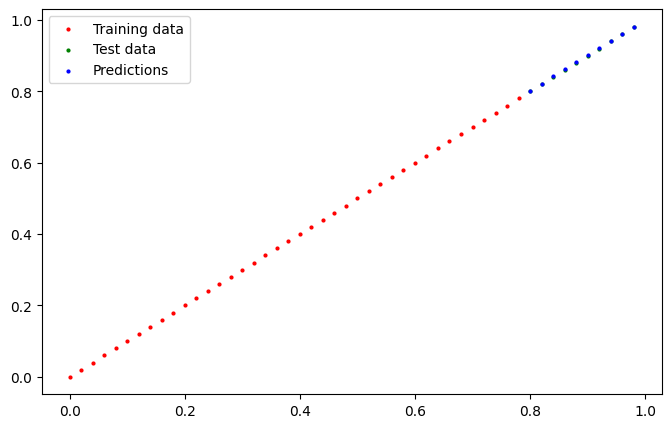

In [93]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

In [94]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [95]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [96]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')